**Skin Condition Classifier using ResNet50**
==========================================================

- This notebook builds an image classification model using transfer learning with ResNet50.

- It classifies six skin conditions: Acne, Carcinoma, Eczema, Keratosis, Milia, and Rosacea.


# 📦 1. Import Libraries and Configure Environment


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


# 📁 2. Load Dataset and Split into Train / Validation / Test Sets

In [2]:
import tensorflow as tf

# Config
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/Skin_Conditions'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# Load full dataset with integer labels
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    label_mode='int'  # ✅ Use integer class labels (0–5)
)

# Extract class names once
class_names = full_dataset.class_names
print("✅ Class labels:", class_names)

# Cache and prefetch the full dataset
AUTOTUNE = tf.data.AUTOTUNE
full_dataset = full_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)

# Compute total batches
total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * total_batches)
val_size = int(0.15 * total_batches)
test_size = total_batches - train_size - val_size

# Split into train, val, test
train_data = full_dataset.take(train_size)
val_data = full_dataset.skip(train_size).take(val_size)
test_data = full_dataset.skip(train_size + val_size)

# Final prefetching
train_data = train_data.prefetch(AUTOTUNE)
val_data = val_data.prefetch(AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)

# Confirm split sizes
print(f"✅ Train batches: {train_size}")
print(f"✅ Validation batches: {val_size}")
print(f"✅ Test batches: {test_size}")


Found 2396 files belonging to 6 classes.
✅ Class labels: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
✅ Train batches: 52
✅ Validation batches: 11
✅ Test batches: 12


# 🖼️ 3. Visual Inspection of Sample Images

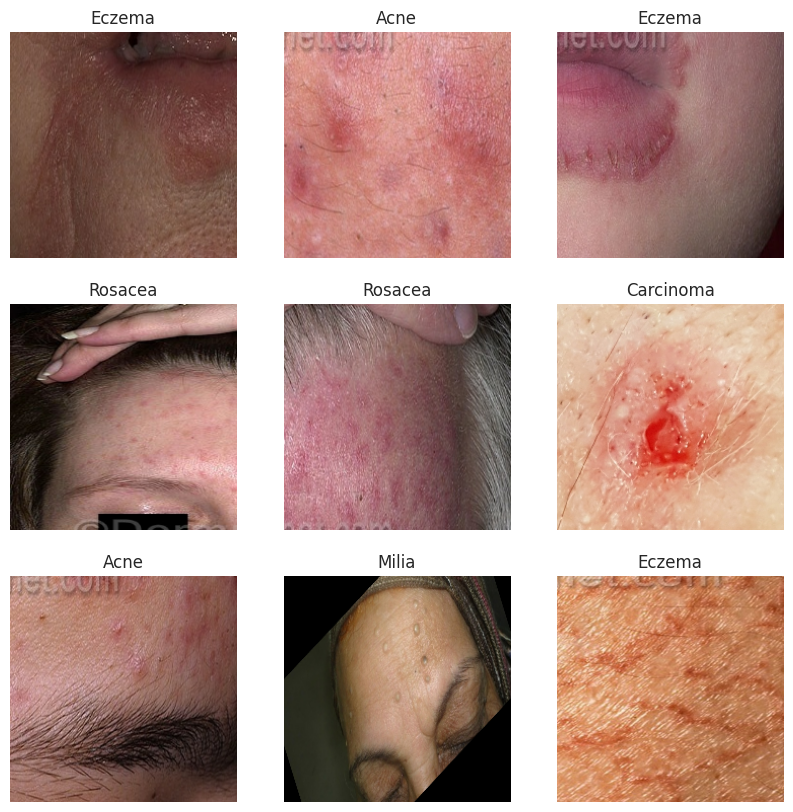

In [6]:
# Show sample images from train_ds
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# 🏗️ 4. Build the ResNet50 Transfer Learning Model

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

IMG_SHAPE = (224, 224, 3)
base_model_resnet = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model_resnet.trainable = False  # Freeze pretrained layers

resnet_model = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input),  # ResNet50-specific preprocessing
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Output layer: 6 classes
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


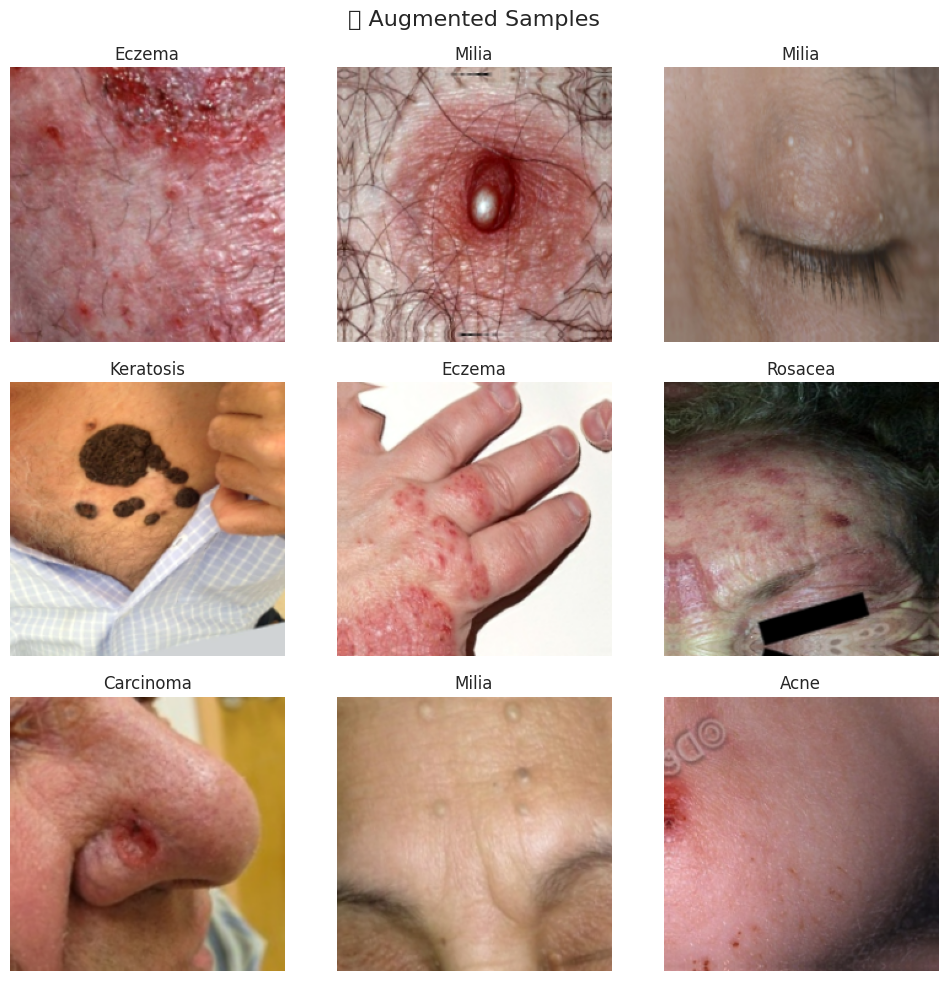

In [13]:
def show_augmented_samples(train_data, data_augmentation, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in train_data.take(1):
        augmented_images = data_augmentation(images, training=True)
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = augmented_images[i].numpy().astype("uint8")
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_names[labels[i].numpy()])
    plt.suptitle("🔁 Augmented Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
show_augmented_samples(train_data, data_augmentation, class_names)


# ⚙️ 5. Compile the Model

In [5]:
resnet_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# 🚀 6. Train Model with Callbacks

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_resnet_model.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

history = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5193 - loss: 1.3005
Epoch 1: val_loss improved from inf to 0.49513, saving model to best_resnet_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 947s 11s/step - accuracy: 0.5216 - loss: 1.2943 - val_accuracy: 0.8182 - val_loss: 0.4951
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8017 - loss: 0.5751
Epoch 2: val_loss improved from 0.49513 to 0.40757, saving model to best_resnet_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 647s 11s/step - accuracy: 0.8014 - loss: 0.5756 - val_accuracy: 0.8551 - val_loss: 0.4076
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8268 - loss: 0.4790
Epoch 3: val_loss improved from 0.40757 to 0.29500, saving model to best_resnet_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 592s 11s/step - accuracy: 0.8268 - loss: 0.4794 - val_accuracy: 0.9091 - val_loss: 0.2950
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8524 - loss: 0.3920
Epoch 4: val_loss improved from 0.29500 to 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


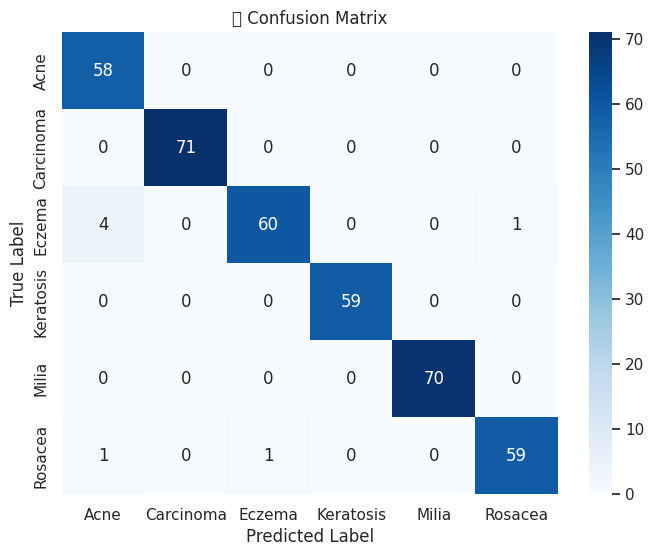


📄 Classification Report:

              precision    recall  f1-score   support

        Acne       0.92      1.00      0.96        58
   Carcinoma       1.00      1.00      1.00        71
      Eczema       0.98      0.92      0.95        65
   Keratosis       1.00      1.00      1.00        59
       Milia       1.00      1.00      1.00        70
     Rosacea       0.98      0.97      0.98        61

    accuracy                           0.98       384
   macro avg       0.98      0.98      0.98       384
weighted avg       0.98      0.98      0.98       384



In [11]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('🔀 Confusion Matrix')
    plt.show()

    print("\n📄 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Example usage
plot_confusion_matrix(best_resnet_model, test_data, class_names)


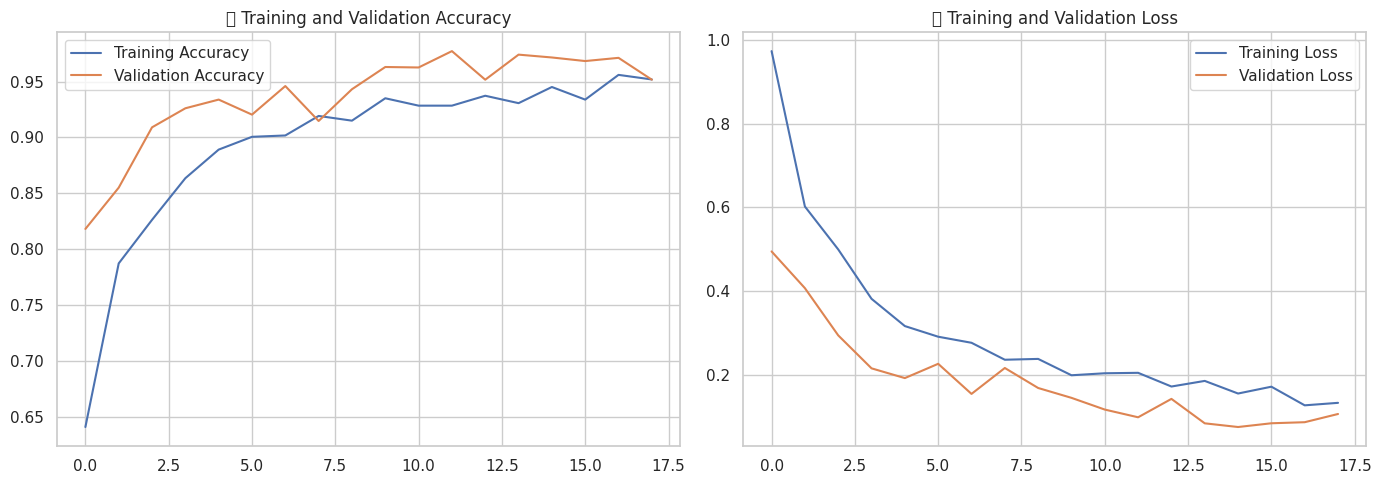

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('✅ Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('📉 Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history)


# 📈 7. Evaluate Final Model on Test Set

In [7]:

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

best_resnet_model = load_model(
    'best_resnet_model.keras',
    custom_objects={'preprocess_input': preprocess_input}
)

test_loss, test_accuracy = best_resnet_model.evaluate(test_data, verbose=1)
print(f"\n📊 Final ResNet50 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Final ResNet50 Test Loss: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 116s 9s/step - accuracy: 0.9622 - loss: 0.1225

📊 Final ResNet50 Test Accuracy: 96.61%
📉 Final ResNet50 Test Loss: 0.1118


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


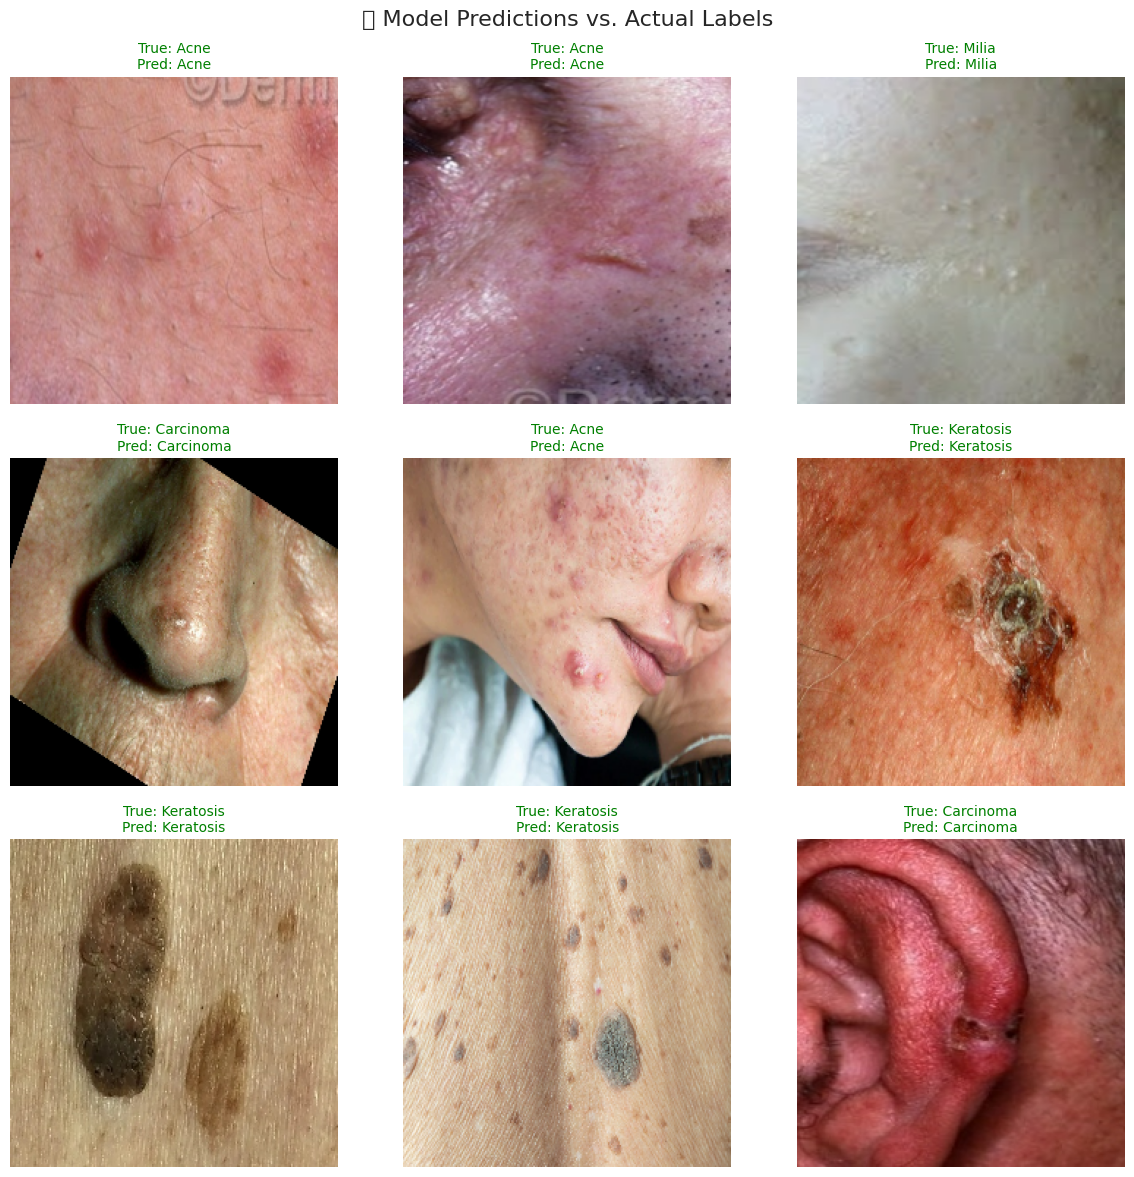

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Your class names
class_names = [
    'Acne',
    'Carcinoma',
    'Eczema',
    'Keratosis',
    'Milia',
    'Rosacea'
]

def plot_random_predictions(test_data, model, class_names, num_images=9):
    """
    Randomly selects and displays predictions on test images.

    Parameters:
        test_data (tf.data.Dataset): The test dataset.
        model (tf.keras.Model): Trained model to evaluate.
        class_names (list): List of class label names.
        num_images (int): Number of images to display (must be a square number).
    """
    fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)), figsize=(12, 12))
    axes = axes.flatten()

    # Take one batch from the test set
    for image_batch, label_batch in test_data.take(1):
        # Predict class probabilities
        predictions = model.predict(image_batch)
        predicted_labels = np.argmax(predictions, axis=1)

        # Choose random indices to visualize
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for i, idx in enumerate(indices):
            img = image_batch[idx].numpy().astype("uint8")
            true_label = label_batch[idx].numpy()
            pred_label = predicted_labels[idx]

            # Display the image
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(
                f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                color='green' if true_label == pred_label else 'red',
                fontsize=10
            )

    plt.suptitle("🔍 Model Predictions vs. Actual Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
plot_random_predictions(test_data, best_resnet_model, class_names)


## Save Model

In [8]:
# Save full model in HDF5 format
resnet_model.save('/content/drive/MyDrive/Colab_Notebooks/resnet_model_skin_condition.h5')


In [9]:
# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/Colab_Notebooks/resnet_model_skin_condition.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpar10jsbf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140288158671952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288158674256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288158676368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288158674448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288158673680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288158675600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288107413968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288107416656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288107417616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140288107414928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1402881074